In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import glob
import re


In [2]:
# Define a key function that extracts numbers from the file name
def natural_sort_key(file_name):
    return [int(num) if num.isdigit() else num for num in re.split(r'(\d+)', file_name)]

file_names = sorted(glob.glob('MFCC-files-v2/*.csv'), key=natural_sort_key)

mfcc_data = []
for file in file_names:
    df = pd.read_csv(file, header = None)
    mfcc_data.append(df)

In [3]:
def compute_variance(data):
    variance_list = []
    for mfcc_df in data:
        mfcc_variance = mfcc_df.var(axis=1)
        variance_list.append(mfcc_variance.values)
    variance_df = pd.DataFrame(variance_list, columns=[f'MFCC_{i+1}_variance' for i in range(20)])
    return variance_df

var_data = compute_variance(mfcc_data)
x_values = var_data.columns
print(compute_variance(mfcc_data))


     MFCC_1_variance  MFCC_2_variance  MFCC_3_variance  MFCC_4_variance  \
0        6800.321317      1290.567948       545.728985       152.591207   
1        9411.835588       992.479757       474.567419       217.617637   
2       11730.099424      1277.782973       800.530984       484.539999   
3        9714.144160      1058.712499       647.129631       484.522483   
4        1635.634335       282.973147       446.179317       311.261132   
..               ...              ...              ...              ...   
111      5844.357447       750.111340       875.757799       360.111430   
112      6010.976405      1093.347400       475.436665       451.748511   
113      8311.712773      1265.476288       908.180436       469.499689   
114      3529.790707       859.247993       838.065960       549.066307   
115      4739.267781      1386.733518       859.606334       283.031183   

     MFCC_5_variance  MFCC_6_variance  MFCC_7_variance  MFCC_8_variance  \
0         154.089920    

In [4]:
var_before_outlier = np.array(var_data.iloc[0, :])
var_before_outlier

array([6800.32131721, 1290.56794759,  545.72898501,  152.5912067 ,
        154.08991962,  144.78879961,  138.93582749,   81.92555411,
         94.10313087,   79.62930218,   80.41776467,   68.79953855,
         70.75669697,   69.82139385,   67.29691563,   68.9983637 ,
         57.84810592,   99.07943165,  125.28773908,  114.09799262])

In [5]:
# Z-score 
def apply_zscore_with_outlier_handling(mfcc_data, threshold=2):
    zscore_data = []
    for mfcc_df in mfcc_data:
        def zscore_outlier_cap(row):
            zscore_row = stats.zscore(row)
            capped_row = [min(threshold, max(-threshold, val)) for val in zscore_row]  # Cap values
            return pd.Series(capped_row)  # Ensure each row returns a Pandas Series, not a list
        
        zscore_df = mfcc_df.apply(zscore_outlier_cap, axis=1)
        zscore_data.append(zscore_df)
    return zscore_data

zscore_outlier_data = apply_zscore_with_outlier_handling(mfcc_data)


In [6]:
def winsorize_data(mfcc_data, lower_percentile=0.02, upper_percentile=0.98):
    winsorized_data = []
    
    for mfcc_df in mfcc_data:
        # Calculate the lower and upper thresholds
        lower_threshold = mfcc_df.quantile(lower_percentile, axis=1)
        upper_threshold = mfcc_df.quantile(upper_percentile, axis=1)

        # Winsorize the DataFrame
        winsorized_df = mfcc_df.copy()
        for i in range(len(mfcc_df)):
            winsorized_df.iloc[i] = mfcc_df.iloc[i].clip(lower=lower_threshold[i], upper=upper_threshold[i])
        
        winsorized_data.append(winsorized_df)

    return winsorized_data

winsorized_data = winsorize_data(mfcc_data)


In [7]:
# Z-score with outlier handling variance table
zscore_outlier_variance_df = compute_variance(zscore_outlier_data)
print("Z-score with Outlier Handling Variance Table:")
print(zscore_outlier_variance_df.head())

# Winsorized variance table
winsorized_variance_df = compute_variance(winsorized_data)
print("\nWinsorized Variance Table:")
print(winsorized_variance_df.head())

Z-score with Outlier Handling Variance Table:
   MFCC_1_variance  MFCC_2_variance  MFCC_3_variance  MFCC_4_variance  \
0         0.803064         0.604944         0.915288         0.870357   
1         0.686144         0.608213         0.836367         0.913572   
2         0.896470         0.853026         0.900156         0.903962   
3         0.667350         0.874328         0.885382         0.836832   
4         0.854717         0.844515         0.916540         0.877655   

   MFCC_5_variance  MFCC_6_variance  MFCC_7_variance  MFCC_8_variance  \
0         0.934953         0.929051         0.940156         0.905022   
1         0.949718         0.899033         0.910876         0.924163   
2         0.937780         0.918118         0.900394         0.887867   
3         0.865961         0.938895         0.959047         0.905624   
4         0.892784         0.938491         0.895270         0.914909   

   MFCC_9_variance  MFCC_10_variance  MFCC_11_variance  MFCC_12_variance  \


In [8]:
var_after_outlier_zscore = np.array(zscore_outlier_variance_df.iloc[0, :])
var_after_outlier_winsorize = np.array(winsorized_variance_df.iloc[0, :])

In [9]:
np.arange(20) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

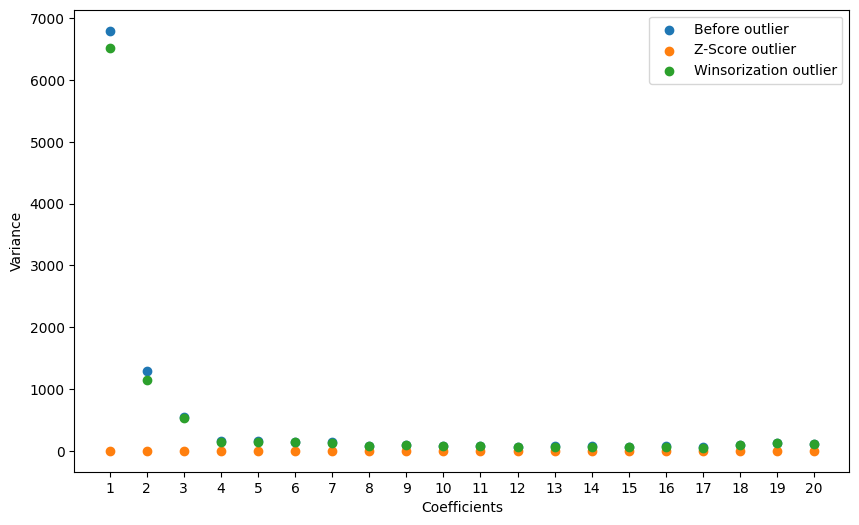

In [10]:
plt.figure(figsize=(10,6))

# for i in range(5):
plt.scatter(np.arange(20) + 1, var_before_outlier, label = 'Before outlier')
plt.scatter(np.arange(20) + 1, var_after_outlier_zscore, label = 'Z-Score outlier')
plt.scatter(np.arange(20) + 1, var_after_outlier_winsorize, label = 'Winsorization outlier')
plt.xticks(np.arange(20) + 1)
plt.xlabel('Coefficients')
plt.ylabel('Variance')


plt.legend()
plt.show()

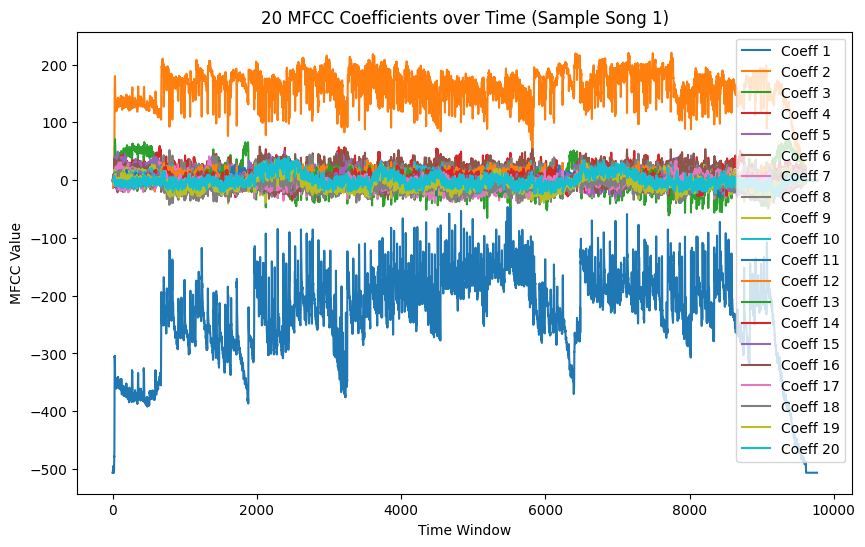

In [11]:
# Plot MFCC coefficients over time for one song (e.g., Song 0)
plt.figure(figsize=(10, 6))

for i in range(20):  # Plotting first 5 MFCC coefficients as an example
    plt.plot(mfcc_data[0].iloc[i, :], label=f'Coeff {i+1}')
    
plt.title('20 MFCC Coefficients over Time (Sample Song 1)')
plt.xlabel('Time Window')
plt.ylabel('MFCC Value')
plt.legend()
plt.show()


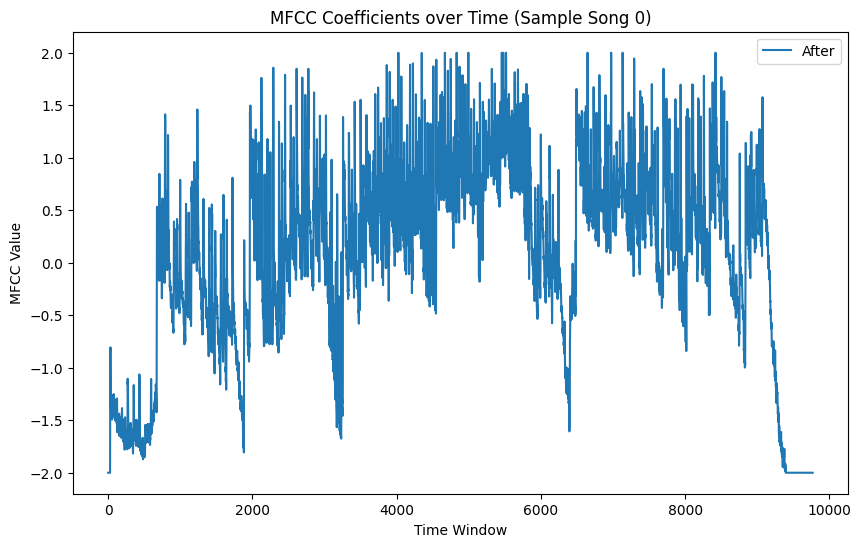

In [12]:
# Plot MFCC coefficients over time for one song (e.g., Song 0)
plt.figure(figsize=(10, 6))

for i in range(1):  # Plotting first 5 MFCC coefficients as an example
    # plt.plot(mfcc_data[0].iloc[i, :], label='Before')
    plt.plot(zscore_outlier_data[0].iloc[i, :], label=f'After')
    
    
plt.title('MFCC Coefficients over Time (Sample Song 0)')
plt.xlabel('Time Window')
plt.ylabel('MFCC Value')
plt.legend()
plt.show()


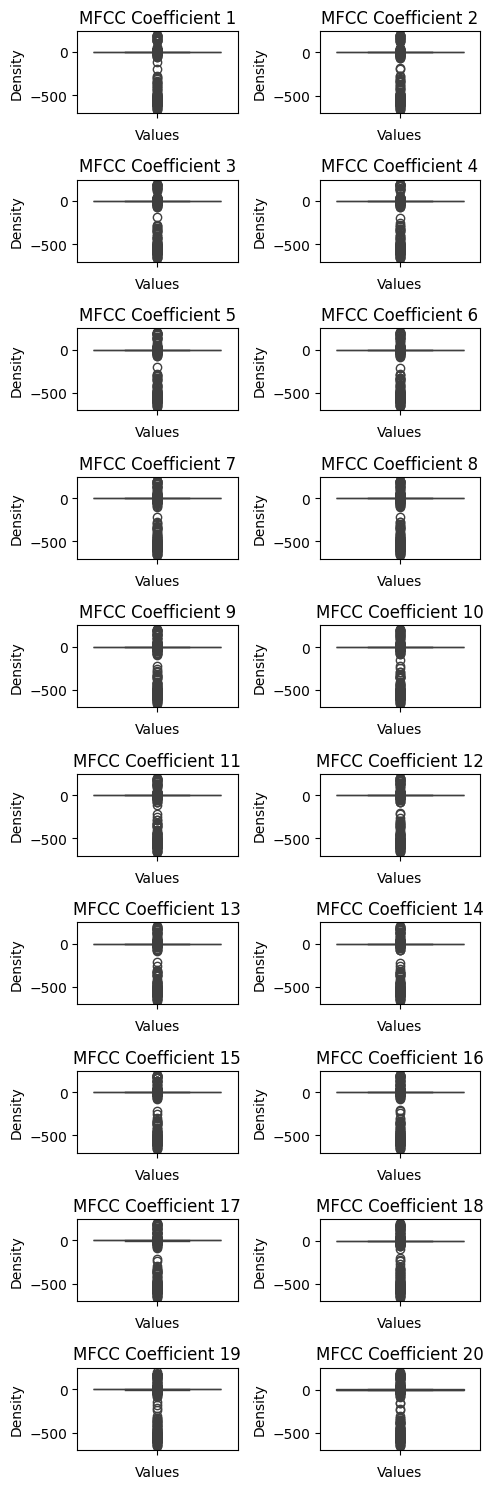

In [13]:
combined_mfcc_df = pd.concat(mfcc_data, ignore_index=True)

# Reshape the data for easier plotting
# Each row will represent an MFCC coefficient across all songs
reshaped_data = combined_mfcc_df.T  # Transpose to have MFCC coefficients as rows

# Generate box plots for each of the 20 MFCC coefficients
plt.figure(figsize=(5, 15))
for i in range(20):
    plt.subplot(10, 2, i + 1)  # Create a grid of subplots (5 rows, 4 columns)
    sns.boxplot(data=reshaped_data.iloc[i])  # Box plot for the ith MFCC coefficient
    plt.title(f'MFCC Coefficient {i + 1}')
    plt.xlabel('Values')
    plt.ylabel('Density')

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

In [14]:
mfcc_data=zscore_outlier_data

In [15]:
def smooth_mfcc_data(data, window_size=3):
    smoothed_data = []

    for mfcc_df in data:
        # Calculate rolling mean and median (axis=1 for rows)
        rolling_mean = mfcc_df.rolling(window=window_size, axis=1, min_periods=1).mean()
        rolling_median = mfcc_df.rolling(window=window_size, axis=1, min_periods=1).median()

        # Fill NaNs at the edges
        rolling_mean.fillna(method='bfill', inplace=True)
        rolling_mean.fillna(method='ffill', inplace=True)

        rolling_median.fillna(method='bfill', inplace=True)
        rolling_median.fillna(method='ffill', inplace=True)

        # Choose either rolling_mean or rolling_median to keep the same structure
        # Here we choose rolling_mean, but you can switch to rolling_median if preferred
        smoothed_data.append(rolling_mean)

    return smoothed_data

# Smooth the MFCC data
smoothed_data = smooth_mfcc_data(mfcc_data)

# Convert the smoothed results back to DataFrames for easier viewing
smoothed_df = pd.concat(smoothed_data, axis=0)

# Display the first few rows of the smoothed DataFrame
print("Smoothed DataFrame (Mean):")
print(smoothed_df.head())

/var/folders/7p/d217p6713972xw562cx4xj880000gp/T/ipykernel_12525/1565928840.py:6: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  rolling_mean = mfcc_df.rolling(window=window_size, axis=1, min_periods=1).mean()
/var/folders/7p/d217p6713972xw562cx4xj880000gp/T/ipykernel_12525/1565928840.py:7: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  rolling_median = mfcc_df.rolling(window=window_size, axis=1, min_periods=1).median()
/var/folders/7p/d217p6713972xw562cx4xj880000gp/T/ipykernel_12525/1565928840.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean.fillna(method='bfill', inplace=True)
/var/folders/7p/d217p6713972xw562cx4xj880000gp/T/ipykernel_12525/1565928840.py:11: FutureWarning: DataFrame.filln

Smoothed DataFrame (Mean):
      0         1         2         3         4         5         6      \
0 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000   
1 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000   
2 -0.075138 -0.075138 -0.075138 -0.075138 -0.075138 -0.075138 -0.075138   
3 -1.399977 -1.399977 -1.399977 -1.399977 -1.399977 -1.399977 -1.399977   
4 -0.748304 -0.748304 -0.748304 -0.748304 -0.748304 -0.748304 -0.748304   

      7         8         9      ...  39741  39742  39743  39744  39745  \
0 -2.000000 -2.000000 -2.000000  ...    NaN    NaN    NaN    NaN    NaN   
1 -2.000000 -2.000000 -2.000000  ...    NaN    NaN    NaN    NaN    NaN   
2  0.025971  0.149119  0.149119  ...    NaN    NaN    NaN    NaN    NaN   
3 -1.432011 -1.475509 -1.475509  ...    NaN    NaN    NaN    NaN    NaN   
4 -0.873971 -1.010630 -1.010630  ...    NaN    NaN    NaN    NaN    NaN   

   39746  39747  39748  39749  39750  
0    NaN    NaN    NaN    NaN   

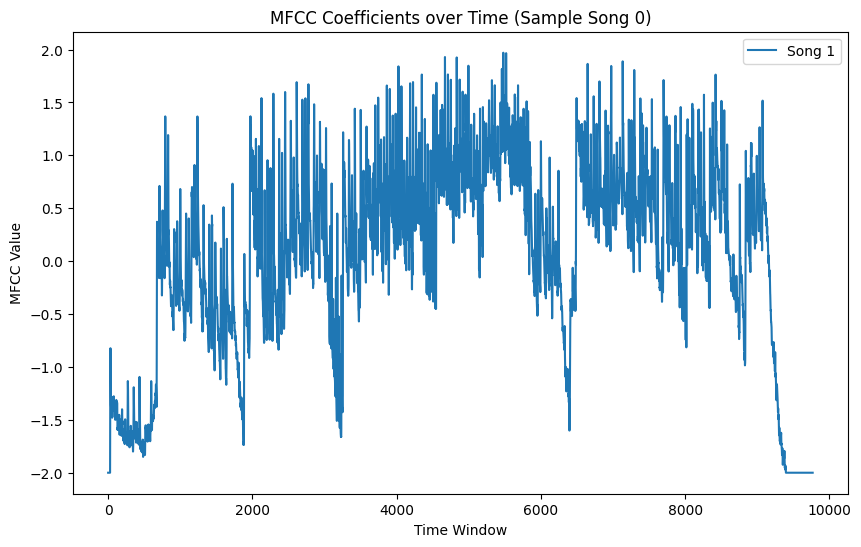

In [16]:
# Plot MFCC coefficients over time for one song (e.g., Song 0)
plt.figure(figsize=(10, 6))

for i in range(1):  # Plotting first 5 MFCC coefficients as an example
    plt.plot(smoothed_data[i].iloc[0, :], label=f'Song {i + 1}')
    
plt.title('MFCC Coefficients over Time (Sample Song 0)')
plt.xlabel('Time Window')
plt.ylabel('MFCC Value')
plt.legend()
plt.show()

In [17]:
mfcc_data=smoothed_data

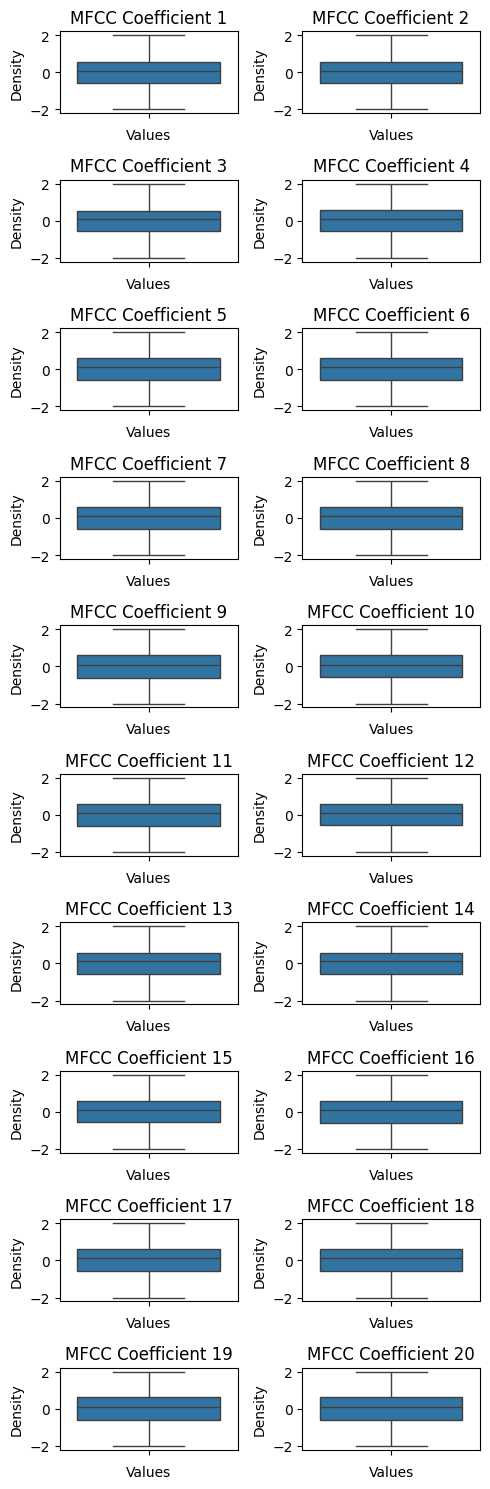

In [18]:
combined_mfcc_df = pd.concat(mfcc_data, ignore_index=True)

# Reshape the data for easier plotting
# Each row will represent an MFCC coefficient across all songs
reshaped_data = combined_mfcc_df.T  # Transpose to have MFCC coefficients as rows

# Generate box plots for each of the 20 MFCC coefficients
plt.figure(figsize=(5, 15))
for i in range(20):
    plt.subplot(10, 2, i + 1)  # Create a grid of subplots (5 rows, 4 columns)
    sns.boxplot(data=reshaped_data.iloc[i])  # Box plot for the ith MFCC coefficient
    plt.title(f'MFCC Coefficient {i + 1}')
    plt.xlabel('Values')
    plt.ylabel('Density')

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

In [19]:
import numpy as np
import librosa
from scipy import stats, signal
import pandas as pd
from scipy.fft import fft
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances

In [20]:
def extract_enhanced_mfcc_features(mfcc_matrix):
    """
    Extract enhanced features from MFCC coefficients matrix, specifically designed
    for music and voice classification.
    
    Parameters:
    mfcc_matrix: numpy array of shape (20, n_timestamps)
        The MFCC coefficients matrix
    
    Returns:
    dict: Dictionary containing extracted features
    """
    features = {}
    
    # 1. Basic Statistical Features (from previous code)
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # Calculate first-order deltas (velocity)
        delta = librosa.feature.delta(coeff.reshape(1, -1), width=19)
        
        # Calculate second-order deltas (acceleration)
        delta_delta = librosa.feature.delta(delta, order=2, width=19)
        
        # Basic statistics for original coefficients
        features[f'mfcc{i}_mean'] = np.mean(coeff)
        features[f'mfcc{i}_std'] = np.std(coeff)
        features[f'mfcc{i}_median'] = np.median(coeff)
        
        # Statistics for deltas (velocity features)
        features[f'mfcc{i}_delta_mean'] = np.mean(delta)
        features[f'mfcc{i}_delta_std'] = np.std(delta)
        features[f'mfcc{i}_delta_max'] = np.max(np.abs(delta))
        
        # Statistics for delta-deltas (acceleration features)
        features[f'mfcc{i}_delta2_mean'] = np.mean(delta_delta)
        features[f'mfcc{i}_delta2_std'] = np.std(delta_delta)
        features[f'mfcc{i}_delta2_max'] = np.max(np.abs(delta_delta))
        
        # Temporal variation features
        features[f'mfcc{i}_delta_zero_crossings'] = np.sum(np.diff(np.signbit(delta)))
        features[f'mfcc{i}_delta2_zero_crossings'] = np.sum(np.diff(np.signbit(delta_delta)))
        
        # Energy-related features
        features[f'mfcc{i}_delta_energy'] = np.sum(delta ** 2)
        features[f'mfcc{i}_delta2_energy'] = np.sum(delta_delta ** 2)
        
        # Ratio features
        features[f'mfcc{i}_delta_energy_ratio'] = features[f'mfcc{i}_delta_energy'] / np.sum(coeff ** 2)
        features[f'mfcc{i}_delta2_energy_ratio'] = features[f'mfcc{i}_delta2_energy'] / features[f'mfcc{i}_delta_energy']

    # 2. Rhythm-based Features
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # Detect peaks in the coefficient
        peaks, _ = signal.find_peaks(coeff)
        if len(peaks) > 1:
            # Average distance between peaks (rhythm indicator)
            features[f'mfcc{i}_peak_distance_mean'] = np.mean(np.diff(peaks))
            features[f'mfcc{i}_peak_distance_std'] = np.std(np.diff(peaks))
        else:
            features[f'mfcc{i}_peak_distance_mean'] = 0
            features[f'mfcc{i}_peak_distance_std'] = 0
        
        # Number of peaks normalized by length
        features[f'mfcc{i}_peak_density'] = len(peaks) / len(coeff)
    
    # 3. Spectral Features
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # FFT for frequency analysis
        fft_vals = np.abs(fft(coeff))
        
        # Spectral centroid (brightness of sound)
        freqs = np.fft.fftfreq(len(coeff))
        features[f'mfcc{i}_spectral_centroid'] = np.sum(freqs * fft_vals) / np.sum(fft_vals)
        
        # Spectral rolloff (shape of spectrum)
        cumsum = np.cumsum(fft_vals)
        rolloff_point = np.where(cumsum >= 0.85 * cumsum[-1])[0][0]
        features[f'mfcc{i}_spectral_rolloff'] = rolloff_point / len(fft_vals)
    
    # 4. Temporal Segmentation Features
    segment_size = mfcc_matrix.shape[1] // 3  # Split into three segments
    
    for i in range(20):
        coeff = mfcc_matrix[i, :]
        
        # Features for beginning, middle, and end of song
        features[f'mfcc{i}_begin_mean'] = np.mean(coeff[:segment_size])
        features[f'mfcc{i}_middle_mean'] = np.mean(coeff[segment_size:2*segment_size])
        features[f'mfcc{i}_end_mean'] = np.mean(coeff[2*segment_size:])
    
    # 5. Cross-MFCC Dynamic Features
    # Compute pairwise differences between consecutive frames
    deltas = np.diff(mfcc_matrix, axis=1)
    
    # Overall dynamics
    features['total_dynamics'] = np.mean(np.abs(deltas))
    features['dynamics_std'] = np.std(deltas)
    
    # Compute acceleration (second-order differences)
    accel = np.diff(deltas, axis=1)
    features['total_acceleration'] = np.mean(np.abs(accel))
    features['acceleration_std'] = np.std(accel)
    
    # 6. Structural Features
    # Silence detection (low energy frames)
    energy = np.sum(mfcc_matrix ** 2, axis=0)
    silence_threshold = np.mean(energy) * 0.1
    silence_frames = np.sum(energy < silence_threshold)
    features['silence_ratio'] = silence_frames / len(energy)
    
    # Variation over time windows
    window_size = min(100, mfcc_matrix.shape[1] // 10)
    for i in range(0, 20, 4):  # Take every 4th coefficient to reduce dimensionality
        coeff = mfcc_matrix[i, :]
        windows = np.array_split(coeff, 10)  # Split into 10 windows
        window_means = [np.mean(w) for w in windows]
        features[f'mfcc{i}_temporal_variation'] = np.std(window_means)
    
    return features

def get_feature_importance(X, y, n_estimators=100):
    """
    Train a Random Forest classifier and return feature importance
    """
    from sklearn.ensemble import RandomForestClassifier
    
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance_dict = dict(zip(X.columns, rf.feature_importances_))
    return dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

def visualize_features(features_df, target_labels=None):
    """
    Create visualizations of the features
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Select top numerical columns (exclude file_name and other non-numeric)
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(features_df[numeric_cols].corr(), cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    if target_labels is not None:
        # Box plots for top features by class
        for col in numeric_cols[:5]:  # Plot top 5 features
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=target_labels, y=features_df[col])
            plt.title(f'{col} Distribution by Class')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

In [21]:
mfcc_df = pd.concat(mfcc_data, ignore_index=True)

# Convert the DataFrame to a numpy array
mfcc_array = mfcc_df.values.reshape(len(mfcc_data), 20, -1).transpose((0, 2, 1))

# Apply the feature extraction function
features_list = []
for i in range(mfcc_array.shape[0]):
    mfcc_matrix = mfcc_array[i]
    features = extract_enhanced_mfcc_features(mfcc_matrix)
    features_list.append(features)

# Convert the list of feature dicts to a DataFrame
features_df = pd.DataFrame(features_list)

In [22]:
features_df

,mfcc0_mean,mfcc0_std,mfcc0_median,mfcc0_delta_mean,mfcc0_delta_std,mfcc0_delta_max,mfcc0_delta2_mean,mfcc0_delta2_std,mfcc0_delta2_max,mfcc0_delta_zero_crossings,...,total_dynamics,dynamics_std,total_acceleration,acceleration_std,silence_ratio,mfcc0_temporal_variation,mfcc4_temporal_variation,mfcc8_temporal_variation,mfcc12_temporal_variation,mfcc16_temporal_variation
0,-0.248425,0.852077,0.010436,0.122741,0.012926,0.135668,2.032879e-21,0.000057,0.000057,0,...,NaN,NaN,NaN,NaN,0.0,0.788924,0.788924,0.763546,0.789145,0.788924
1,-0.194918,1.098041,0.139586,0.092858,0.006184,0.099042,6.390017e-19,0.000027,0.000027,0,...,NaN,NaN,NaN,NaN,0.0,0.811458,0.811458,0.810506,0.835456,0.885559
2,-0.257072,0.843482,-0.082819,0.042038,0.011442,0.053480,-5.102526e-19,0.000051,0.000051,0,...,NaN,NaN,NaN,NaN,0.0,0.597244,0.596697,0.610122,0.597244,0.597244
3,-0.369011,1.029883,-0.229206,0.032791,0.011491,0.044282,-5.014435e-20,0.000051,0.000051,0,...,NaN,NaN,NaN,NaN,0.0,0.565130,0.565130,0.565130,0.565130,0.565130
4,0.206738,1.176911,0.072748,0.066249,0.023733,0.089982,-6.274820e-19,0.000105,0.000105,0,...,NaN,NaN,NaN,NaN,0.0,0.910106,0.963665,0.879628,0.892629,0.839084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,-0.060201,0.972312,0.017385,0.054849,0.019972,0.074821,-3.726945e-19,0.000088,0.000088,0,...,NaN,NaN,NaN,NaN,0.0,0.706462,0.706462,0.706462,0.706462,0.706462
112,-0.097091,1.009047,0.052050,0.045725,0.015032,0.060758,-7.182839e-19,0.000066,0.000066,0,...,NaN,NaN,NaN,NaN,0.0,0.651762,0.651762,0.651762,0.651762,0.651762
113,-0.266617,0.887823,-0.099556,0.088932,0.008655,0.097586,-2.886688e-19,0.000038,0.000038,0,...,NaN,NaN,NaN,NaN,0.0,0.709292,0.709292,0.709292,0.709292,0.709292
114,-0.233604,0.727020,-0.146551,0.046025,0.016620,0.062644,-3.455894e-19,0.000074,0.000074,0,...,NaN,NaN,NaN,NaN,0.0,0.658837,0.844010,0.878517,0.778467,0.794452


In [23]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(features_df)
data_standardized_df = pd.DataFrame(data_standardized, columns=features_df.columns)
data_standardized_df.to_csv("final_test.csv")


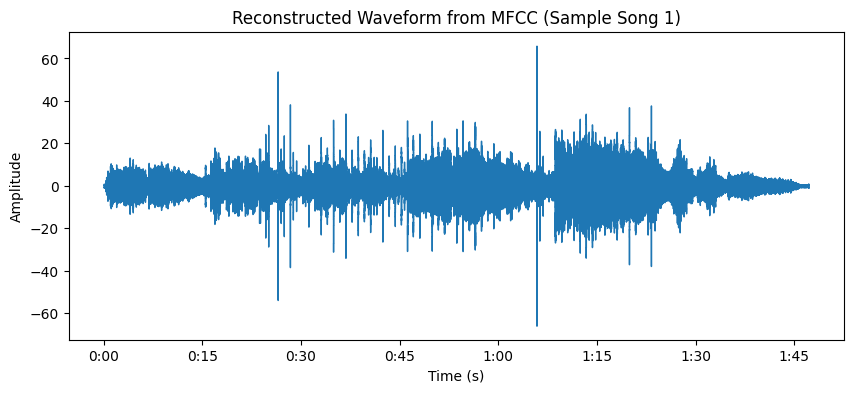

In [24]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the MFCC coefficients from a CSV file
mfcc_df = pd.read_csv('MFCC-files-v2/02-MFCC.csv')
mfcc_data = mfcc_df.values  # Convert to numpy array

# Parameters (these should match the parameters used during MFCC extraction)
sr = 44100  # Sampling rate used in your MFCC extraction
n_mfcc = mfcc_data.shape[0]  # Number of MFCC coefficients

# Step 2: Inverse MFCC transformation
# Convert MFCCs back to mel spectrogram

mel_spec = librosa.feature.inverse.mfcc_to_mel(mfcc_data, n_mels=128)

# Convert mel spectrogram to a linear spectrogram
spec = librosa.feature.inverse.mel_to_stft(mel_spec, sr=sr)

# Step 3: Reconstruct the waveform using the Griffin-Lim algorithm
reconstructed_audio = librosa.griffinlim(spec)

# Save or display the waveform
#librosa.output.write_wav('reconstructed_audio.wav', reconstructed_audio, sr)

# Optional: Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(reconstructed_audio, sr=sr)
plt.title('Reconstructed Waveform from MFCC (Sample Song 1)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()